# Jupyter notebook for fitting a regression model to the data based on a tensorflow neural network for regression


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
import os

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle

import PlottingHelpers
import ProcessingHelpers
from LoadData import load_data

importlib.reload(ProcessingHelpers)
importlib.reload(PlottingHelpers)


<module 'PlottingHelpers' from 'C:\\Users\\kwesendrup\\PycharmProjects\\master\\Multiple\\PlottingHelpers.py'>

In [65]:
sns.set() 

# Load Data into Workspace

In [66]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [68]:
# get the first data set training data
df = dc['FD_001']['df_train'].copy()

# Prepare Data
## Make a Column for the RUL target data (y)

According to the data description document the data set contains multiple units, each unit starts at a certain degradation point and the measurement data ends closely before the unit was decommissioned of broke. 

Therefore assume, that for the last measurement time that is available for a unit the units RUL=0 (stopped measuring just before machine broke)


In [69]:
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']

## Drop the nan columns and rows

In [70]:
cols_nan = df.columns[df.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(df[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']



In [71]:
df = df.drop(columns=cols_const + cols_nan)

## Perform an averaging with a floating average window of size 10 to smoothen out the signal noise

In [72]:
df_old = df.copy()
df = ProcessingHelpers.rolling_mean_by_unit(df_old, 10)
df.iloc[0:9]

unit_nr  time    os_1    os_2   sensor_02    sensor_03    sensor_04  \
0        1     1 -0.0007 -0.0004  641.820000  1589.700000  1400.600000   
1        1     2  0.0019 -0.0003  641.985000  1590.760000  1401.870000   
2        1     3 -0.0043  0.0003  642.106667  1589.836667  1402.646667   
3        1     4  0.0007  0.0000  642.167500  1588.075000  1402.452500   
4        1     5 -0.0019 -0.0002  642.208000  1587.030000  1403.206000   
5        1     6 -0.0043 -0.0001  642.190000  1586.603333  1402.400000   
6        1     7  0.0010  0.0001  642.231429  1587.420000  1401.738571   
7        1     8 -0.0034  0.0003  642.272500  1586.862500  1401.642500   
8        1     9  0.0008  0.0001  642.255556  1587.320000  1400.882222   

    sensor_07    sensor_08    sensor_09  sensor_11   sensor_12    sensor_13  \
0  554.360000  2388.060000  9046.190000  47.470000  521.660000  2388.020000   
1  554.055000  2388.050000  9045.130000  47.480000  521.970000  2388.045000   
2  554.123333  2388.060000  9047.733333  47.410000  522.120000  2388.040000   
3  554.205000  2388.072500  9048.170000  47.340000  522.305000  2388.050000   
4  554.164000  2388.070000  9049.566000  47.328000  522.282000  2388.048000   
5  554.248333  2388.061667  9049.585000  47.300000  522.181667  2388.045000   
6  554.261429  2388.055714  9050.948571  47.308571  522.201429  2388.042857   
7  554.210000  2388.048750  9049.680000  47.300000  522.235000  2388.041250   
8  554.152222  2388.048889  9049.322222  47.298889  522.185556  2388.042222   

     sensor_14  sensor_15   sensor_17  sensor_20  sensor_21  RUL  
0  8138.620000   8.419500  392.000000  39.060000  23.419000  191  
1  8135.055000   8.425650  392.000000  39.030000  23.421300  190  
2  8134.446667   8.423033  391.333333  39.003333  23.395600  189  
3  8134.292500   8.409325  391.500000  38.972500  23.390175  188  
4  8134.194000   8.413340  391.800000  38.958000  23.393020  187  
5  8133.970000   8.412917  391.666667  38.961667  23.388667  186  
6  8133.734286   8.410700  391.714286  38.981429  23.387057  185  
7  8133.401250   8.410312  391.625000  38.980000  23.377500  184  
8  8132.544444   8.406144  391.666667  38.987778  23.380733  183

In [73]:
df_old.iloc[0:9]

unit_nr  time    os_1    os_2  sensor_02  sensor_03  sensor_04  sensor_07  \
0        1     1 -0.0007 -0.0004     641.82    1589.70    1400.60     554.36   
1        1     2  0.0019 -0.0003     642.15    1591.82    1403.14     553.75   
2        1     3 -0.0043  0.0003     642.35    1587.99    1404.20     554.26   
3        1     4  0.0007  0.0000     642.35    1582.79    1401.87     554.45   
4        1     5 -0.0019 -0.0002     642.37    1582.85    1406.22     554.00   
5        1     6 -0.0043 -0.0001     642.10    1584.47    1398.37     554.67   
6        1     7  0.0010  0.0001     642.48    1592.32    1397.77     554.34   
7        1     8 -0.0034  0.0003     642.56    1582.96    1400.97     553.85   
8        1     9  0.0008  0.0001     642.12    1590.98    1394.80     553.69   

   sensor_08  sensor_09  sensor_11  sensor_12  sensor_13  sensor_14  \
0    2388.06    9046.19      47.47     521.66    2388.02    8138.62   
1    2388.04    9044.07      47.49     522.28    2388.07    8131.49   
2    2388.08    9052.94      47.27     522.42    2388.03    8133.23   
3    2388.11    9049.48      47.13     522.86    2388.08    8133.83   
4    2388.06    9055.15      47.28     522.19    2388.04    8133.80   
5    2388.02    9049.68      47.16     521.68    2388.03    8132.85   
6    2388.02    9059.13      47.36     522.32    2388.03    8132.32   
7    2388.00    9040.80      47.24     522.47    2388.03    8131.07   
8    2388.05    9046.46      47.29     521.79    2388.05    8125.69   

   sensor_15  sensor_17  sensor_20  sensor_21  RUL  
0     8.4195        392      39.06    23.4190  191  
1     8.4318        392      39.00    23.4236  190  
2     8.4178        390      38.95    23.3442  189  
3     8.3682        392      38.88    23.3739  188  
4     8.4294        393      38.90    23.4044  187  
5     8.4108        391      38.98    23.3669  186  
6     8.3974        392      39.10    23.3774  185  
7     8.4076        391      38.97    23.3106  184  
8     8.3728        392      39.05    23.4066  183


### Features by unit and RUL, before averaging

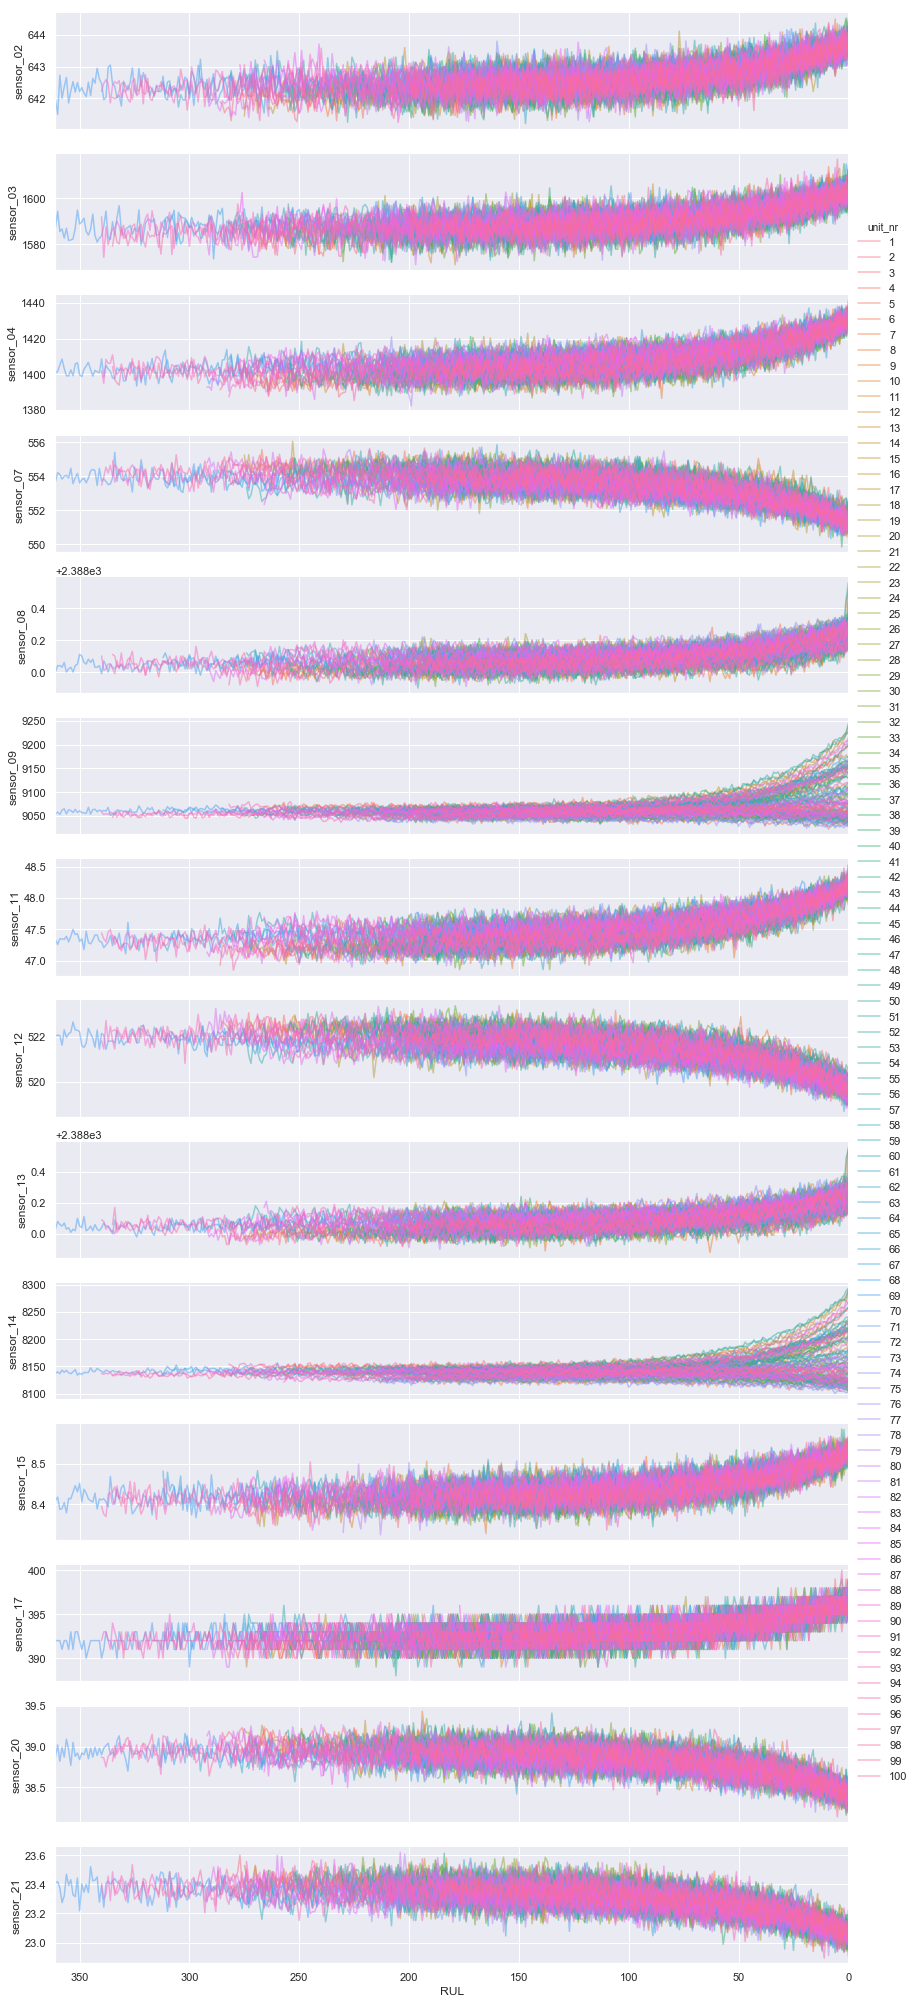

In [74]:
cols = [c for c in df.columns if c.startswith('s') or c in ['RUL', 'unit_nr']]
PlottingHelpers.plot_grouped_by_RUL(df_old[cols].copy())

### Features by unit and RUL, after averaging

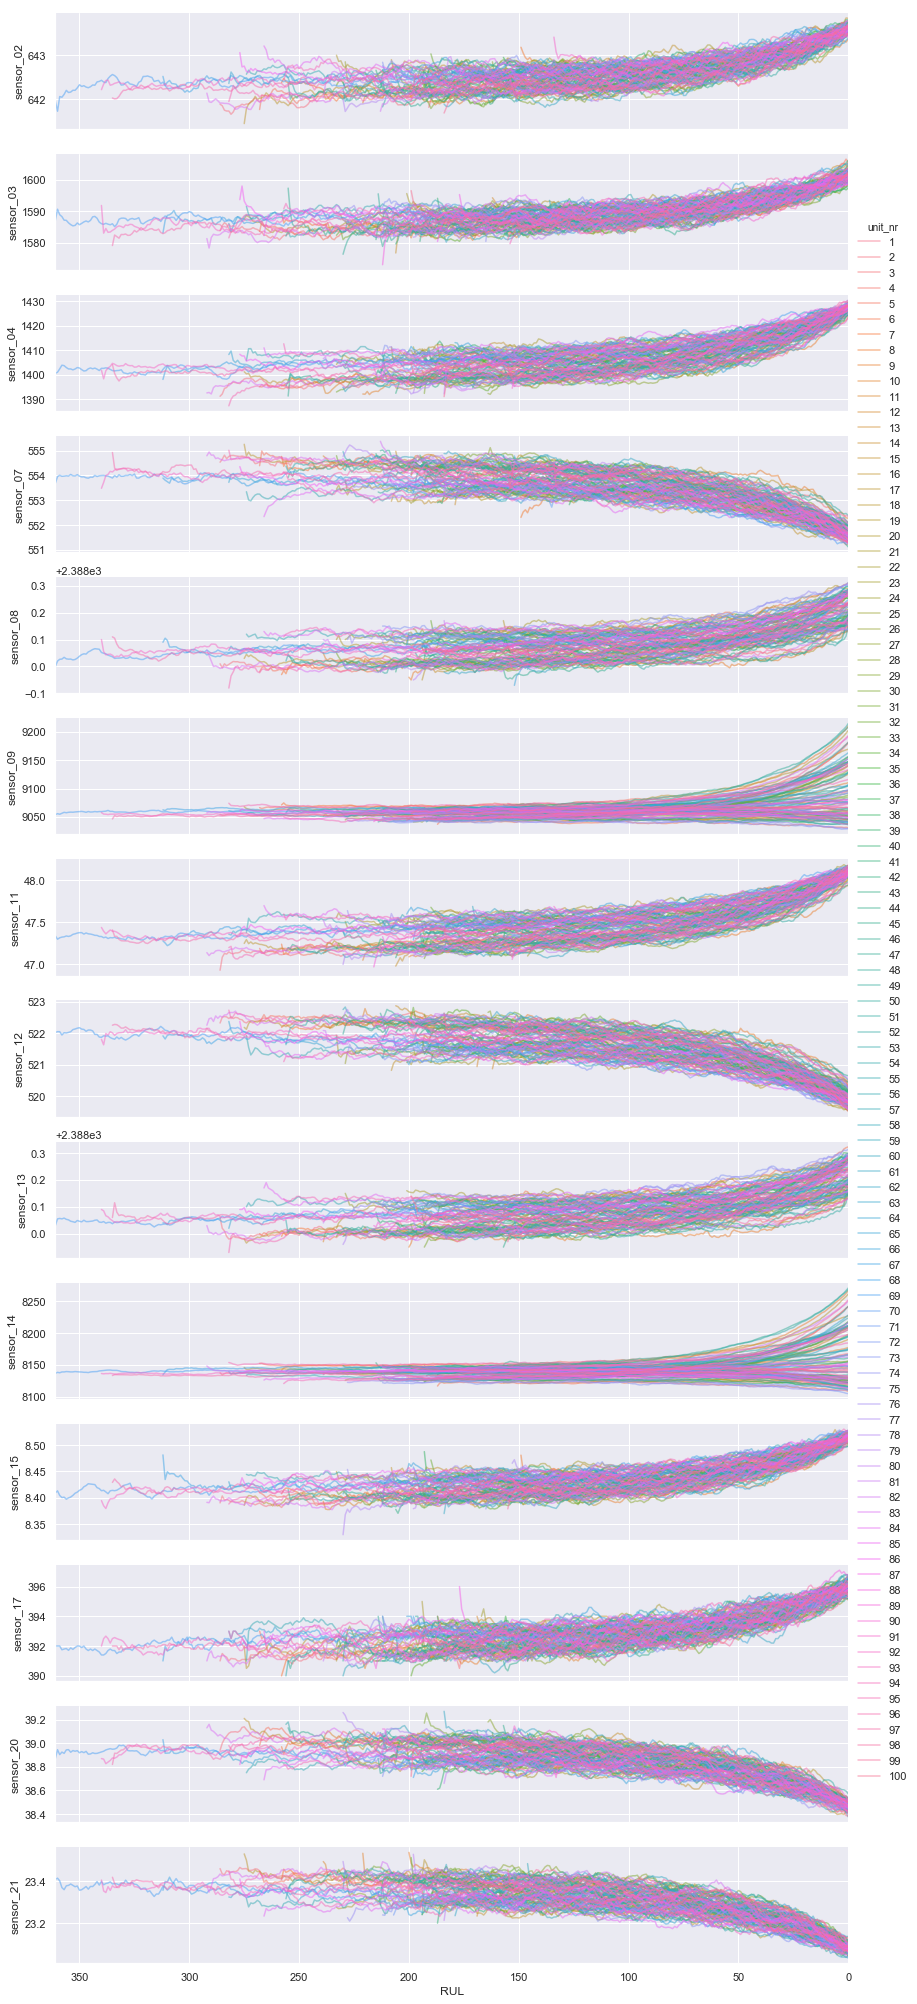

In [75]:
cols = [c for c in df.columns if c.startswith('s') or c in ['RUL', 'unit_nr']]
PlottingHelpers.plot_grouped_by_RUL(df[cols].copy())

## Take out a certain percentage of units from the training data set for testing:

In [76]:
units = df['unit_nr'].unique()
n_units = len(df['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_test = df.loc[df['unit_nr'].apply( lambda x: x in units_test )].copy()
df_train = df.loc[df['unit_nr'].apply( lambda x: x in units_train )].copy()

## Normalize the dataset by mean and std

In [77]:
f_exclude = ['sensor_09', 'sensor_14']
cols_features = [c for c in df_train.columns if c.startswith('s') and c not in f_exclude]

train_data = df_train[cols_features].values
train_labels = df_train['RUL'].values

test_data = df_test[cols_features].values
test_labels = df_test['RUL'].values

In [78]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-2.19882232 -0.11864784 -1.0229851   1.26503459 -0.54710405 -0.23994834
  0.32672496 -1.17983628 -0.68521163 -0.96638035  1.63749055  1.43710948]


In [79]:
mean

array([ 642.65809319, 1590.23271257, 1408.39233027,  553.41388765,
       2388.09354085,   47.52583444,  521.45209832, 2388.09311339,
          8.44016378,  393.13490158,   38.82575272,   23.2953836 ])

## Define some helper functions

In [80]:
def plot_res(model, test_data, test_labels, train_data, train_labels):
    [loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
    [loss, mae_train] = model.evaluate(train_data, train_labels, verbose=0)
    print("Testing set Mean Abs Error:  {:7.2f}".format(mae))
    print("Training set Mean Abs Error: {:7.2f}".format(mae_train))
    test_predictions = model.predict(test_data).flatten()
    train_predictions = model.predict(train_data).flatten()
    sns.distplot(train_predictions - train_labels)
    sns.distplot(test_predictions - test_labels)
    _ = plt.xlabel("Prediction Error")

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation loss')
    plt.legend()
    
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


# Build tensorflow model
our model consists of a simple 3 layered feedforward model with 24 nodes per layer. The output layer is a simple linear summing layer, which maps to the target values 

In [81]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(24, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(24, activation=tf.nn.relu),
        keras.layers.Dense(24, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    
    return model

In [82]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Train the model and validate it using the test data taken out before

Also make the training process stop in case there is stagnation in the loss function of the validation data for more than 20 epochs

In [83]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

EPOCHS=500
train_data2, train_labels2 = shuffle(train_data, train_labels)
history = model.fit(train_data2, train_labels2, epochs=EPOCHS, 
                    verbose=1,
                    validation_data = (test_data, test_labels),
                    callbacks=[early_stop, PrintDot()])

Train on 16453 samples, validate on 4178 samples
Epoch 1/500
16453/16453 [==============================] - 1s 53us/sample - loss: 6174.1627 - mean_absolute_error: 58.6804 - val_loss: 1900.3235 - val_mean_absolute_error: 35.2613
Epoch 2/500
16453/16453 [==============================] - 1s 44us/sample - loss: 2007.7050 - mean_absolute_error: 33.2145 - val_loss: 1753.9554 - val_mean_absolute_error: 32.9683
Epoch 3/500
16453/16453 [==============================] - 1s 46us/sample - loss: 1949.7449 - mean_absolute_error: 32.4618 - val_loss: 1553.6667 - val_mean_absolute_error: 31.0282
Epoch 4/500
16453/16453 [==============================] - 1s 44us/sample - loss: 1915.8802 - mean_absolute_error: 31.9006 - val_loss: 1629.1645 - val_mean_absolute_error: 31.3272
Epoch 5/500
16453/16453 [==============================] - 1s 44us/sample - loss: 1889.1517 - mean_absolute_error: 31.4794 - val_loss: 1559.9236 - val_mean_absolute_error: 30.5242
Epoch 6/500
16453/16453 [==========================

### Plot convergence over epochs 

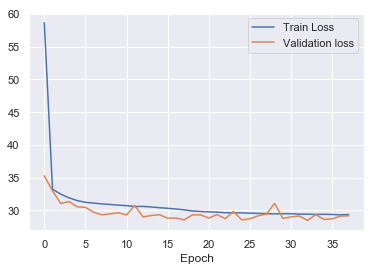

In [84]:
# 1) Underfitting – Validation and training error high
# 2) Overfitting – Validation error is high, training error low
# 3) Good fit – Validation error low, slightly higher than the training error
# 4) Unknown fit - Validation error low, training error 'high'
plot_history(history)

That looks like the models are converging well. Lets take a look at the errors and their distributions.

### Plot prediciton error distibution

Testing set Mean Abs Error:    29.15
Training set Mean Abs Error:   29.12


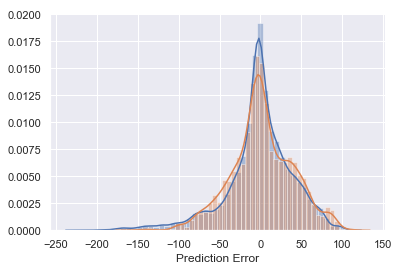

In [85]:
plot_res(model, test_data, test_labels, train_data, train_labels)

Ok, the errors are more or less evenly distributed around zero. The width of the distribution seems pretty high, lets take a look at the predictions, actual values and errors over time. 

### Plot the predicted RULs over the lifecycle of each unit, for the test data set:

C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


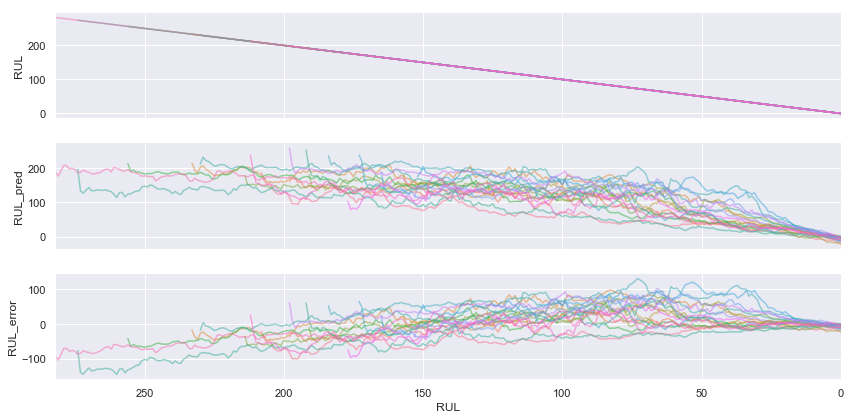

In [20]:
test_predictions = model.predict(test_data).flatten()
tmp = df_test[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = test_predictions - test_labels
tmp.loc[:,'RUL_pred'] = test_predictions

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

### Plot the predicted RULs over the lifecycle of each unit, for the training data set:

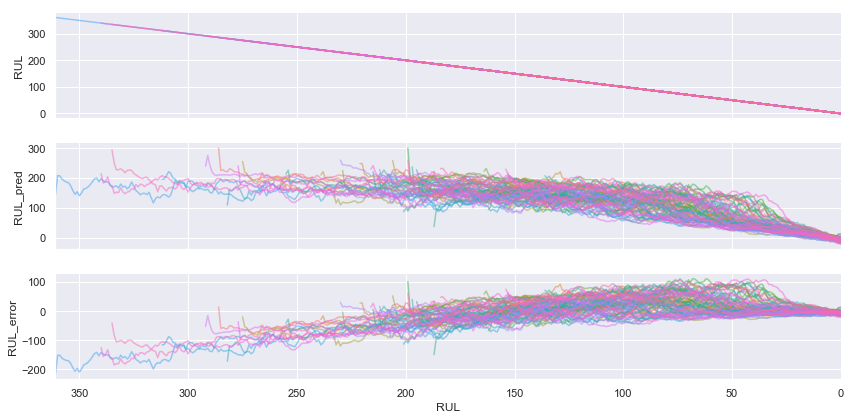

In [21]:
train_predictions = model.predict(train_data).flatten()
tmp = df_train[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = train_predictions - train_labels
tmp.loc[:,'RUL_pred'] = train_predictions

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])


The predicted RULs are especially off at the beginning of the life cycle of a unit, but seem to get closer the more a machine nears to the end of it's life. This is especially valuable, when it comes to protecting the unit from damage, or scheduling maintenance closely to a breakdown.

Looking at the data shown above when applying the windowed mean data, it seems intuitive, since the whole state of the units seem to stay relatively close to the comissioningstate for a long time and then starts deviating more the closer it comes the the end of its life cycle.

## Train another model but this time, let tensorflow take its own validation data based on 20% of the training data

In [22]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model = build_model()
EPOCHS=500
train_data2, train_labels2 = shuffle(train_data, train_labels)
history = model.fit(train_data2, train_labels2, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
........................................................

### Plot convergence over epochs 

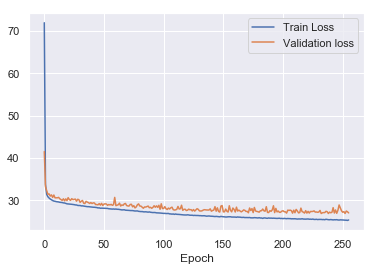

In [23]:
plot_history(history)

That looks like the models are converging well. Lets take a look at the errors and their distributions.

### Plot prediciton error distibution

Testing set Mean Abs Error:    31.68
Training set Mean Abs Error:   25.41


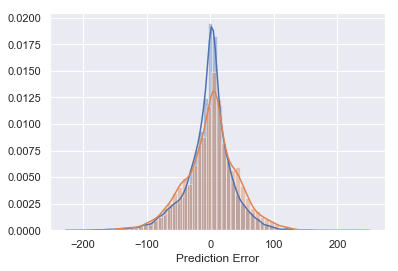

In [24]:
plot_res(model, test_data, test_labels, train_data, train_labels)

Ok, the errors are more or less evenly distributed around zero. The with of the distribution seems pretty high, lets take a look at the predictions, actual values and errors over time. 

### Plot the predicted RULs over the lifecycle of each unit, for the test data set:

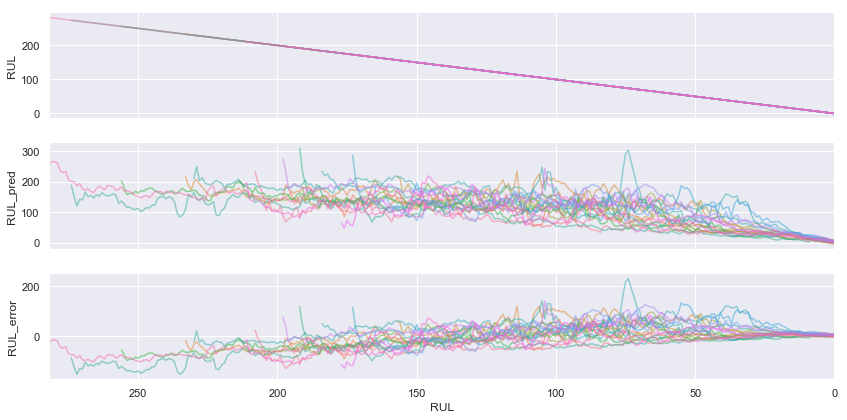

In [25]:
test_predictions = model.predict(test_data).flatten()
tmp = df_test[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = test_predictions - test_labels
tmp.loc[:,'RUL_pred'] = test_predictions

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

### Plot the predicted RULs over the lifecycle of each unit, for the training data set:

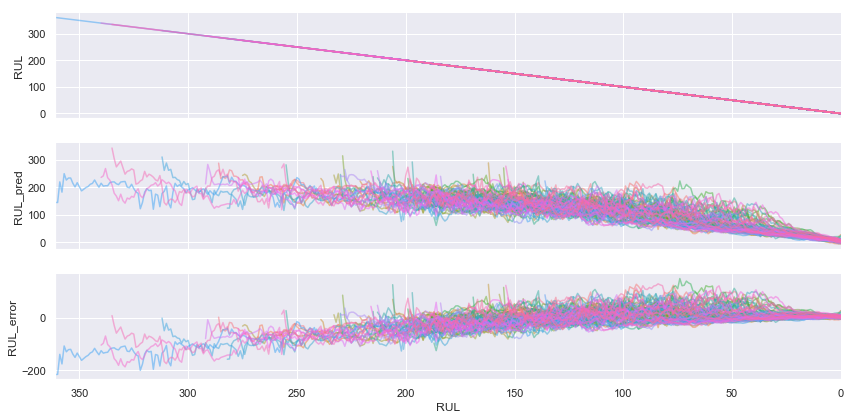

In [26]:
train_predictions = model.predict(train_data).flatten()
tmp = df_train[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = train_predictions - train_labels
tmp.loc[:,'RUL_pred'] = train_predictions

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

# Results
 
The predicited values for the trained models look ok, and get more reliable, the closer a unit nears the end of its lifecycle. Looking only at the last 30 cycles of the RUL shows:

Testing set Mean Abs Error:    10.39
Training set Mean Abs Error:    7.43


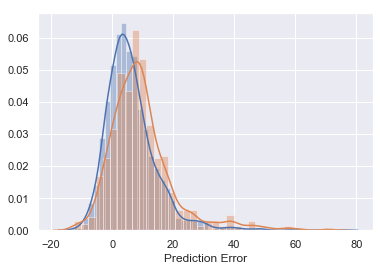

In [27]:
idx_test_end = test_labels < 30.0
idx_train_end = train_labels < 30.0

plot_res(model, test_data[idx_test_end], test_labels[idx_test_end], train_data[idx_train_end], train_labels[idx_train_end])

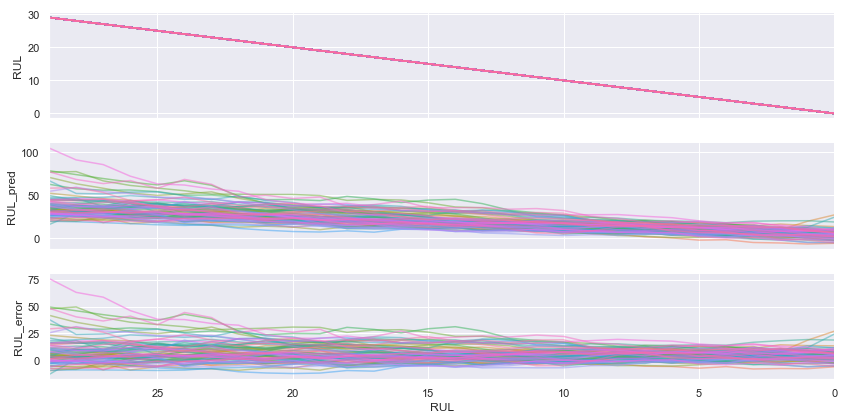

In [28]:
train_predictions = model.predict(train_data).flatten()
tmp = df_train[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = train_predictions - train_labels
tmp.loc[:,'RUL_pred'] = train_predictions
tmp = tmp[tmp['RUL'] < 30.0]
PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

Which is much better, than what we saw above. This is good when it comes to protecting the unit from imminent danger and scheduling maintenance. This however can better be accomplished by modelling the problem as a classification problem. (See other notebooks) 

# Summary

The following things can be found:
- The RUL estimation for RUL > 30 cycles is not very accurate, but reliable since it will get more accurate the smaller the actual RUL. 
- The RUL estimation for RUL <= 30 cycles is relatively accurate.
- The units can be protected from breakdown and maintenenance/decomissioning can be sheduled safely some dozen cycles in advance before actual failure.
- The imminent failure/protection problem is better modelled as a binary classification problem (see other notebooks)


